In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Data

In [3]:
import seaborn as sns
data = sns.load_dataset('iris')
df = torch.tensor(data.drop(columns="species").values).float()
labels = torch.zeros(len(df), dtype=torch.long)
labels[data.species == 'versicolor'] = 1 
labels[data.species == 'virginica'] = 2

In [4]:
df.shape

torch.Size([150, 4])

# TensorDataset and DataLoader

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, train_size=0.8)
tf_train = TensorDataset(x_train, y_train)
tf_test = TensorDataset(x_test, y_test)

train = DataLoader(tf_train, batch_size=64, shuffle=True)
test = DataLoader(tf_test, batch_size=tf_test.tensors[0].shape[0])

# Model

In [11]:
class model(nn.Module):
    def __init__(self, dropoutrate):
        super().__init__()
        self.input = nn.Linear(4, 12)
        self.hidden = nn.Linear(12, 12)
        self.output = nn.Linear(12, 3)
        self.dr = dropoutrate
    def forward(self, x):
        # input layer and dropout
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training) 
        # self.training is set to true when the model is in train mode and off in eval mode
        # hidden layer and drop out
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        y = self.output(x)
        return y

In [12]:
tempnet = model(.25)

In [13]:
tempx = torch.randn((10,4))
tempyhat = tempnet(tempx)

In [14]:
print(tempyhat)

tensor([[ 0.1346, -0.1157,  0.1626],
        [ 0.0893, -0.1032,  0.0740],
        [ 0.2506, -0.1751,  0.0245],
        [ 0.2776, -0.1165,  0.1368],
        [-0.0068, -0.2138,  0.1491],
        [ 0.1969, -0.0983,  0.0688],
        [ 0.4318, -0.1601, -0.1868],
        [ 0.2161, -0.1692,  0.0174],
        [ 0.3917, -0.1789, -0.0061],
        [ 0.0918, -0.1564,  0.1663]], grad_fn=<AddmmBackward0>)


In [15]:
def create_model(dropoutrate):
    ann = model(dropoutrate)
    lossfn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.02)
    return ann, lossfn, optimizer 

In [40]:
numepochs = 500
def train_model(ann, lossfn, optimizer):
    trainacc = []
    testacc = []

    for i in range(numepochs):
        ann.train()
        batchacc = []
        for x, y in train:
            yhat = ann(x)
            loss = lossfn(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchacc.append(100*torch.mean((torch.argmax(yhat, axis=1)==y).float()).item())
        trainacc.append(np.mean(batchacc))

        ann.eval()
        x,y = next(iter(test))
        yhat = ann(x)
        testacc.append(100*torch.mean((torch.argmax(yhat, axis=1)==y).float()).item())
    return trainacc, testacc


In [41]:
dropoutrate = 0
ann, loss, opt = create_model(dropoutrate)

In [42]:
trainacc, testacc = train_model(ann, loss, opt)

In [43]:
trainacc[:5]

[35.82589328289032,
 36.04910671710968,
 35.37946492433548,
 35.60267835855484,
 38.05803507566452]

In [44]:
testacc[:5]

[23.333333432674408,
 23.333333432674408,
 23.333333432674408,
 26.66666805744171,
 26.66666805744171]

<function matplotlib.pyplot.show(close=None, block=None)>

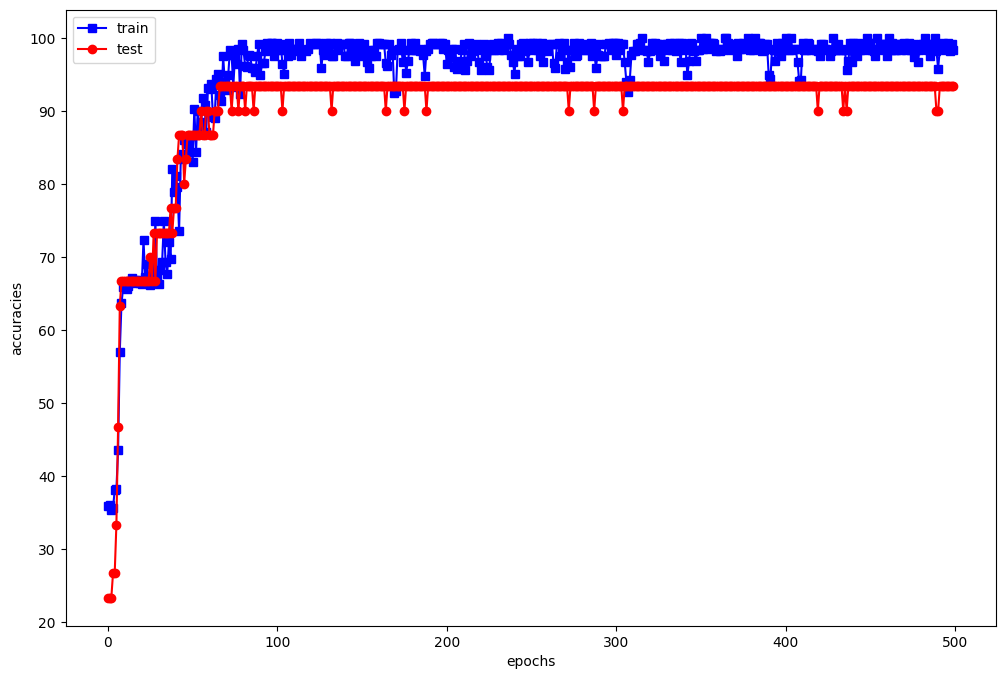

In [45]:
plt.figure(figsize=(12,8))
plt.plot(trainacc, 'bs-')
plt.plot(testacc, 'ro-')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(['train', 'test'])
plt.show


# Experiment

In [28]:
dropouts = np.arange(10)/10
results = np.zeros((len(dropouts),2))
trainacc = []
testacc = []

In [29]:
dropouts

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [30]:
results

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [31]:
for i in range(len(dropouts)):
    ann, loss, opt = create_model(dropouts[i])
    trainacc, testacc = train_model(ann, loss, opt)
    results[i,0] = np.mean(trainacc[-100:])
    results[i,1] = np.mean(testacc[-100:])

In [32]:
results

array([[97.71651822, 93.16666698],
       [90.18973196, 93.33333373],
       [87.22098207, 93.33333373],
       [83.75558046, 93.36666697],
       [74.95535702, 93.36666697],
       [71.52232155, 89.69999927],
       [62.94084826, 66.36666775],
       [59.62388404, 81.36666679],
       [46.8158481 , 57.53333348],
       [35.53794646, 56.03333348]])

<function matplotlib.pyplot.show(close=None, block=None)>

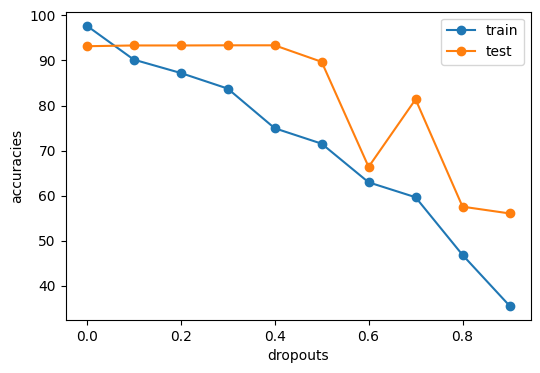

In [36]:
plt.figure(figsize=(6,4))
plt.plot(dropouts,results, 'o-')
plt.xlabel('dropouts')
plt.ylabel('accuracies')
plt.legend(['train', 'test'])
plt.show
